### Face detection with RetinaFace

> References: 
> - https://github.com/biubug6/Pytorch_Retinaface 

In [1]:
# default_exp face_detection.retinaface

In [2]:
#export
from fastai.vision import *
from dfdc.core.video_core import *
from dfdc.face_detection.bbox_utils import *

device = defaults.device
retinaface_stats = tensor([123,117,104]).to(device) # RGB stats for retina face

### RetinaFace

In [4]:
#export
sys.path.insert(0,"/home/ubuntu/git/dfdc/local_misc/")

import torch.backends.cudnn as cudnn

In [5]:
from pytorch_retinaface.data import cfg_mnet, cfg_re50
from pytorch_retinaface.layers.functions.prior_box import PriorBox
from pytorch_retinaface.utils.nms.py_cpu_nms import py_cpu_nms
from pytorch_retinaface.models.retinaface import RetinaFace
from pytorch_retinaface.utils.box_utils import decode, decode_landm

In [6]:
#export
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True


def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [7]:
cfg_re50['image_size'], cfg_mnet['image_size']

(840, 640)

In [8]:
#export
cudnn.benchmark = True # size constant for better runtime

def get_model(modelname="mobilenet"):
    torch.set_grad_enabled(False)
    cfg = None
    cfg_mnet['pretrain'] = False
    cfg_re50['pretrain'] = False
    
    if modelname == "mobilenet": 
        pretrained_path = "/home/ubuntu/git/dfdc/local_misc/pytorch_retinaface/weights/mobilenet0.25_Final.pth"
        cfg = cfg_mnet
    elif modelname == "resnet50":
        pretrained_path = "/home/ubuntu/git/dfdc/local_misc/pytorch_retinaface/weights/Resnet50_Final.pth"
        cfg = cfg_re50
    else: raise Exception(f"only options are: 'mobilenet' or 'resnet50'")
    
    # net and model
    net = RetinaFace(cfg=cfg, phase='test')
    net = load_model(net, pretrained_path, False)
    net.eval().to(device)
    return net, cfg

In [9]:
#export
def predict(model, t, sz, cfg, 
            confidence_threshold = 0.5, top_k = 5, nms_threshold = 0.5, keep_top_k = 5):
    "get prediction for a batch t by model with image sz"

    resize = 1
    scale_rate = 1

    im_height, im_width = sz, sz 
    scale = torch.Tensor([sz, sz, sz, sz])
    scale = scale.to(device)
    
    
    locs, confs, landmss = torch.Tensor([]), torch.Tensor([]), torch.Tensor([])
    locs = locs.to(device)
    confs = confs.to(device)
    landmss = landmss.to(device)
    
    # forward pass
    locs_, confs_, landmss_ = model(t)  
    locs = torch.cat((locs, locs_), 0)
    confs = torch.cat((confs, confs_), 0)
    landmss = torch.cat((landmss, landmss_), 0)
    
    
    bbox_result, landms_result = [], []
    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data
    for idx in range(t.size(0)):
        loc = locs[idx]
        conf = confs[idx]
        landms = landmss[idx]

        boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
        boxes = boxes * scale / resize

        boxes = boxes.cpu().numpy()
        scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
        landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
        scale1 = torch.Tensor([t.shape[3], t.shape[2], t.shape[3], t.shape[2],
                            t.shape[3], t.shape[2], t.shape[3], t.shape[2],
                            t.shape[3], t.shape[2]])
        scale1 = scale1.to(device)
        landms = landms * scale1 / resize
        landms = landms.cpu().numpy()

        # ignore low scores
        inds = np.where(scores > confidence_threshold)[0]
        boxes = boxes[inds]
        landms = landms[inds]
        scores = scores[inds]

        # keep top-K before NMS
        order = scores.argsort()[::-1][:top_k]
        boxes = boxes[order]
        landms = landms[order]
        scores = scores[order]

        # do NMS
        dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
        keep = py_cpu_nms(dets, nms_threshold)

        # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
        dets = dets[keep, :]
        landms = landms[keep]
    
        # keep top-K faster NMS
        dets = dets[:keep_top_k, :]
        landms = landms[:keep_top_k, :]

    #     dets = np.concatenate((dets, landms), axis=1)
    #     dets = np.concatenate((dets, landms), axis=1)
        bbox_result.append(dets[:,:-1]) # don't keep confidence score
        landms_result.append(landms)
    
    return  bbox_result, landms_result

### Predict and visualize

In [10]:
model, cfg = get_model("mobilenet")

Loading pretrained model from /home/ubuntu/git/dfdc/local_misc/pytorch_retinaface/weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300


In [11]:
video_files = get_files("/home/ubuntu/data/dfdc/dfdc_train/dfdc_train_part_49/", extensions=['.mp4'])

In [12]:
sample_video_fname = np.random.choice(video_files)
freq = 10

model_args = dict(confidence_threshold = 0.5, top_k = 5, nms_threshold = 0.5, keep_top_k = 5)
sz = cfg['image_size']
t, t_raw, (H,W), len_video = get_decord_video_batch_cpu(sample_video_fname, freq, sz, retinaface_stats)

In [13]:
bboxes, landmarks = predict(model, t, sz, cfg, **model_args)

In [14]:
orig_bboxes = bboxes_to_original_scale(bboxes, H, W, sz)
orig_landmarks = landmarks_to_original_scale(landmarks, H, W, sz)

orig_bboxes = [o.tolist() for o in orig_bboxes]
orig_landmarks = [o.tolist() for o in orig_landmarks]

In [15]:
bb_scale = 1.3

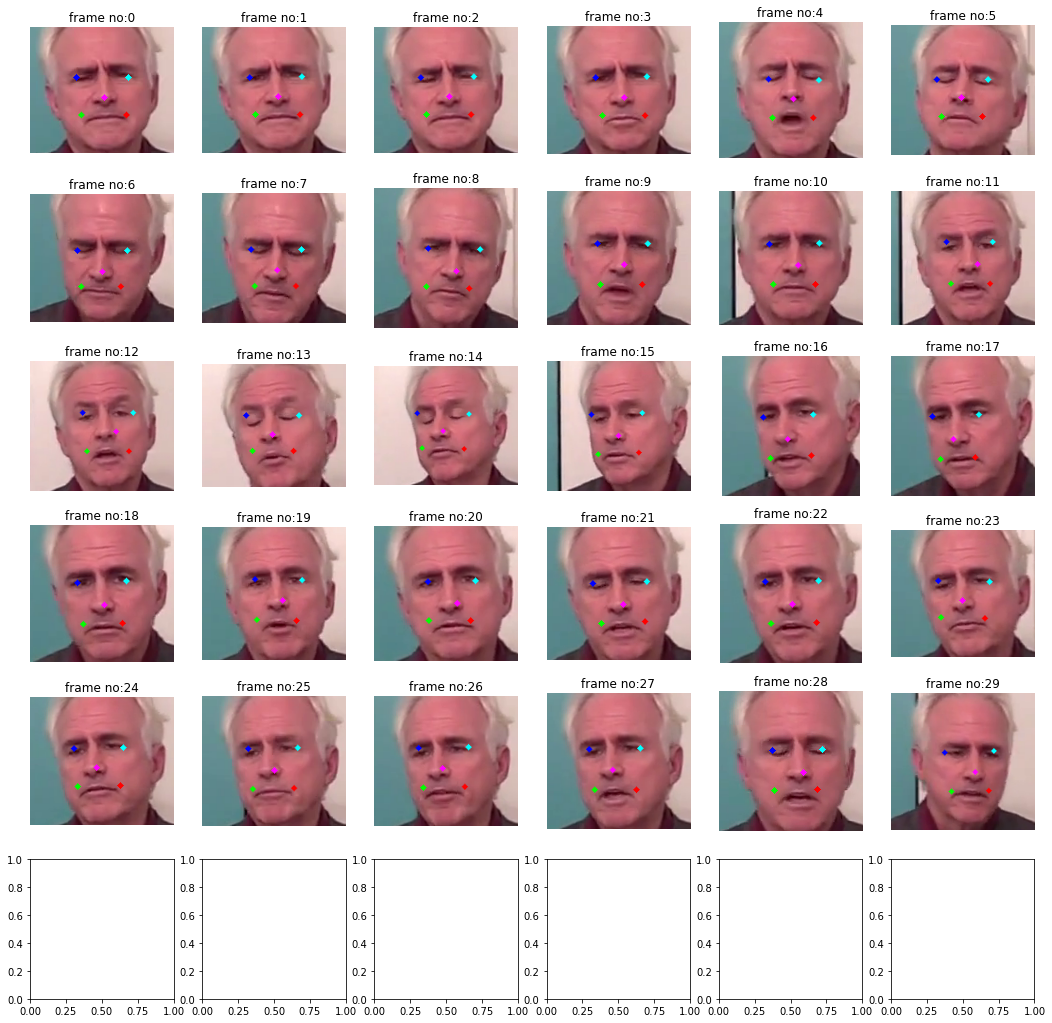

In [16]:
import cv2
n = int(np.ceil(np.sqrt(t.size(0))))
axes = subplots(n,n, figsize=(3*n,3*n)).flatten()
for idx, (ax, _frame, _bboxes, _lndms) in enumerate(zip(axes, t_raw, orig_bboxes, orig_landmarks)):
    try:
        # pick first bbox and landmarks
        _bb, _lndm = _bboxes[0], _lndms[0]
        
        # draw landmarks
        _frame = to_np(_frame.permute(1,2,0))
        cv2.circle(_frame, (_lndm[0], _lndm[1]), 1, (0, 0, 255), 4)
        cv2.circle(_frame, (_lndm[2], _lndm[3]), 1, (0, 255, 255), 4)
        cv2.circle(_frame, (_lndm[4], _lndm[5]), 1, (255, 0, 255), 4)
        cv2.circle(_frame, (_lndm[6], _lndm[7]), 1, (0, 255, 0), 4)
        cv2.circle(_frame, (_lndm[8], _lndm[9]), 1, (255, 0, 0), 4);
        _frame = tensor(_frame).permute(2,0,1)
        
        # resize bbox and show
        _bb = resize_bbox_by_scale(_bb, bb_scale, H, W)
        left, top, right, bottom = _bb
        img = Image(_frame[:, top:bottom, left:right])
        img.show(ax=ax, title=f"frame no:{idx}")
    except: 
        continue # false negatives
        

### export

In [17]:
from nbdev.export import notebook2script

In [18]:
notebook2script()

Converted 001 - extract_faces.ipynb.
Converted 002 - face_detection_retinaface.ipynb.
Converted 003 - save_face_crops.ipynb.
Converted 004 - tl_baseline.ipynb.
Converted 00_core.ipynb.
Converted 01_video_core.ipynb.
Converted 10_bbox_utils.ipynb.
Converted 11_retinaface_detection.ipynb.
Converted 12_generate_face_detections.ipynb.
Converted 13_save_cropped_faces.ipynb.
Converted 21_baseline_model.ipynb.
Converted index.ipynb.
